In [1]:
import pickle
with open('ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

with open('/srv/scratch/z5297792/Sample/frontier_sample_data.pkl', 'rb') as file:
    frontier_sample_data = pickle.load(file)
print(frontier_sample_data.keys())

import netCDF4 as nc
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import time

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho'][:]
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho'][:]
lat_rho = np.transpose(lat_rho, axes=(1, 0))
f  = dataset.variables['f'][:]
f = np.transpose(f, axes=(1, 0))
h = dataset.variables['h'][:]
h = np.transpose(h, axes=(1, 0))
z_r = np.load('/home/z5297792/UNSW-MRes/MRes/z_r/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))
temp_ave = np.load('/srv/scratch/z5297792/Climatology/temp_ave.npy')
CurSpeed_ave = np.load('/srv/scratch/z5297792/Climatology/CurSpeed_ave.npy')


dict_keys(['Eddy790', 'Eddy110', 'Eddy134', 'Eddy775'])


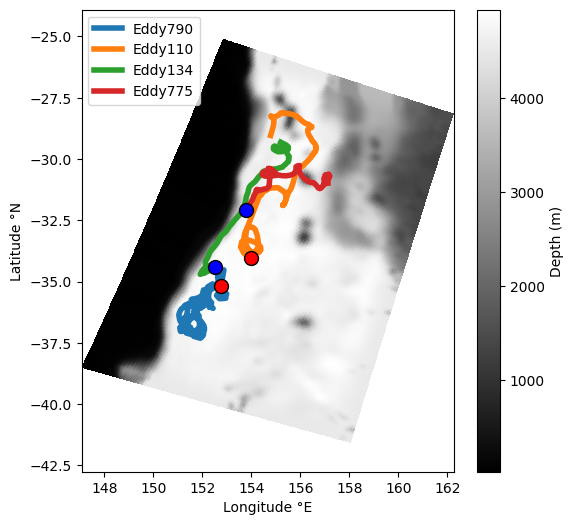

In [2]:
the_frontier_eddies = ['Eddy790', 'Eddy110', 'Eddy134', 'Eddy775']

colors = plt.get_cmap('tab10')
plt.figure(figsize=(6, 6))
plt.pcolormesh(lon_rho, lat_rho, h, shading='auto', cmap='gray')
plt.colorbar(label='Depth (m)')
plt.xlabel('Longitude °E')
plt.ylabel('Latitude °N')
for i, e in enumerate(the_frontier_eddies):
    eddy_data = eddies[e]
    plt.plot(eddy_data['Lon'], eddy_data['Lat'], color=colors(i), label=e, linewidth=4)
    plt.scatter(eddy_data['Lon'].iloc[-1], eddy_data['Lat'].iloc[-1], color='r' if eddy_data['Vort'].iloc[-1] > 0 else 'b', edgecolor='black', s=100, zorder=5)
plt.axis('equal')
plt.legend(loc='upper left')
plt.show()

In [3]:
with open('/srv/scratch/z5297792/Sample/frontier_sample_data.pkl', 'rb') as file:
    frontier_sample_data = pickle.load(file)
the_frontier_eddies = list(frontier_sample_data.keys())
print(the_frontier_eddies)

['Eddy790', 'Eddy110', 'Eddy134', 'Eddy775']


Text(0.5, 0.98, 'Eddy134 - T25')

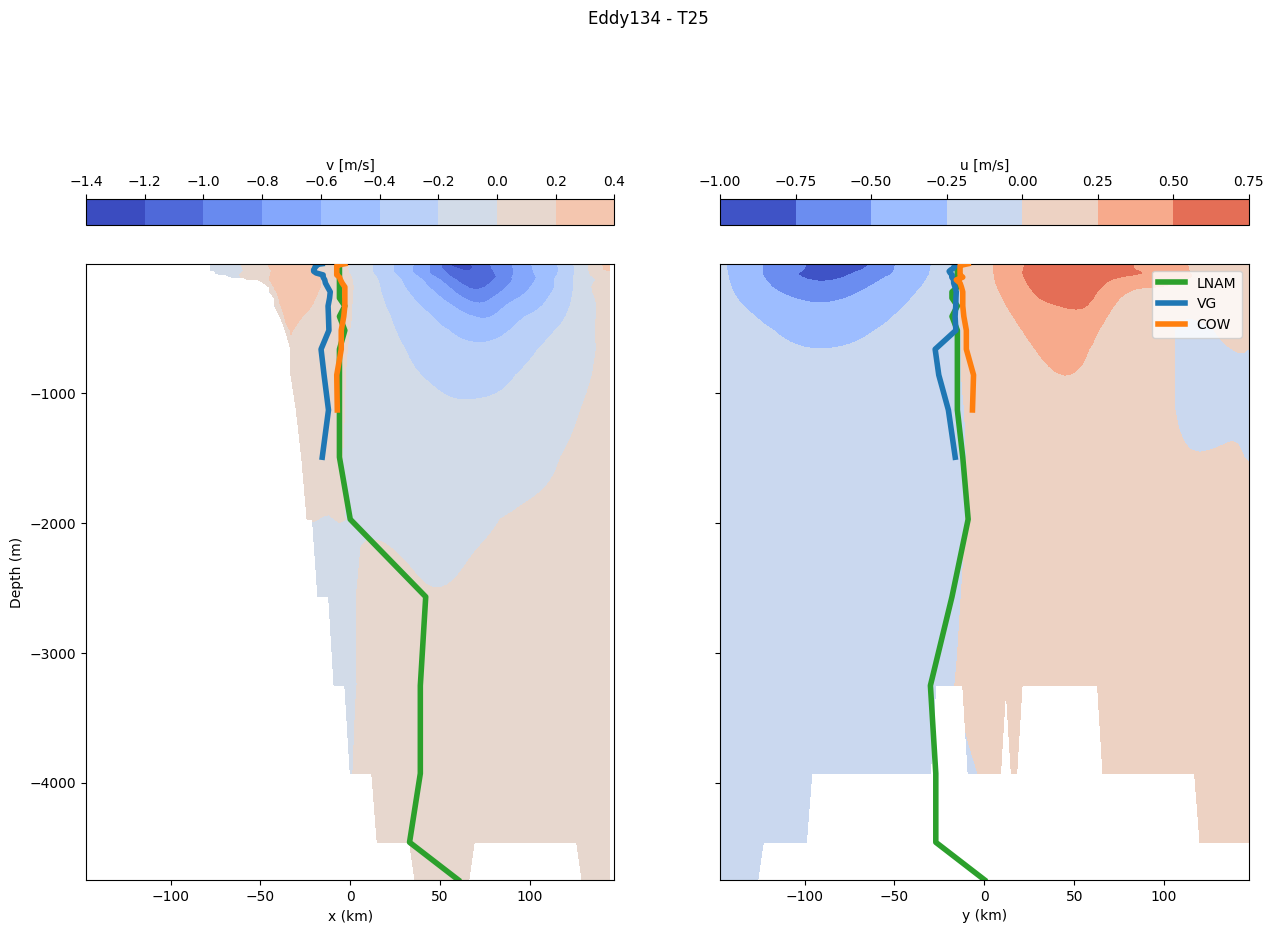

In [79]:
eddy = the_frontier_eddies[2]

t = 25

U = frontier_sample_data[eddy]['T'+str(t)]['U']
V = frontier_sample_data[eddy]['T'+str(t)]['V']
x = frontier_sample_data[eddy]['T'+str(t)]['x']/1000
y = frontier_sample_data[eddy]['T'+str(t)]['y']/1000
z = frontier_sample_data[eddy]['T'+str(t)]['z']
VG_data = frontier_sample_data[eddy]['T'+str(t)]['VG']
COW_data = frontier_sample_data[eddy]['T'+str(t)]['COW']
LNAM_data = frontier_sample_data[eddy]['T'+str(t)]['LNAM']

xc_VG, yc_VG, zc_VG = VG_data.x/1000, VG_data.y/1000, VG_data.Depth
xc_COW, yc_COW, zc_COW = COW_data.x/1000, COW_data.y/1000, COW_data.Depth
xc_LNAM, yc_LNAM, zc_LNAM = LNAM_data.x/1000, LNAM_data.y/1000, LNAM_data.Depth
lengths = {
    "VG": len(zc_VG),
    "COW": len(zc_COW),
    "LNAM": len(zc_LNAM)
}
cmap = plt.colormaps['tab10']
colors = {
    "VG": cmap(0),
    "COW": cmap(1),
    "LNAM": cmap(2)
}
sorted_keys = sorted(lengths, key=lengths.get, reverse=True)

fig, axs = plt.subplots(1, 2, figsize=(15, 10), sharey=True)
X, Z = np.meshgrid(x, z)
v_data_range = np.nanmax(np.abs(V[:, V.shape[1]//2, :]))
c1 = axs[0].contourf(X, Z, V[:, V.shape[1]//2, :].T, cmap = 'coolwarm', vmin=-v_data_range, vmax=v_data_range)
for i, key in enumerate(sorted_keys):
    if key == "VG":
        axs[0].plot(xc_VG, zc_VG, linewidth=4, zorder=i+1, color=colors[key])
    elif key == "COW":
        axs[0].plot(xc_COW, zc_COW, linewidth=4, zorder=i+1, color=colors[key])
    elif key == "LNAM":
        axs[0].plot(xc_LNAM, zc_LNAM, linewidth=4, zorder=i+1, color=colors[key])
axs[0].set_xlabel('x (km)')
axs[0].set_ylabel('Depth (m)')
Y, Z = np.meshgrid(y, z)
u_data_range = np.nanmax(np.abs(U[U.shape[0]//2, :, :]))
c2 = axs[1].contourf(Y, Z, U[U.shape[0]//2, :, :].T, cmap = 'coolwarm', vmin=-u_data_range, vmax=u_data_range)
for i, key in enumerate(sorted_keys):
    if key == "VG":
        axs[1].plot(yc_VG, zc_VG, linewidth=4, zorder=i+1, label=key, color=colors[key])
    elif key == "COW":
        axs[1].plot(yc_COW, zc_COW, linewidth=4, zorder=i+1, label=key, color=colors[key])
    elif key == "LNAM":
        axs[1].plot(yc_LNAM, zc_LNAM, linewidth=4, zorder=i+1, label=key, color=colors[key])
axs[1].set_xlabel('y (km)')
# axs[1].set_ylabel('Depth (m)')
# TD = f"{round(VG_data['TD'][0]/1000)} km" if 'TD' in VG_data and not np.isnan(VG_data['TD'][0]) else 'NaN'
# plt.suptitle(f'VG - TD = {TD}')

fig.colorbar(c1, ax=axs[0], orientation='horizontal', location='top', label='v [m/s]')
fig.colorbar(c2, ax=axs[1], orientation='horizontal', location='top', label='u [m/s]')
plt.legend(loc='best')

plt.suptitle(eddy + ' - T'+str(t))

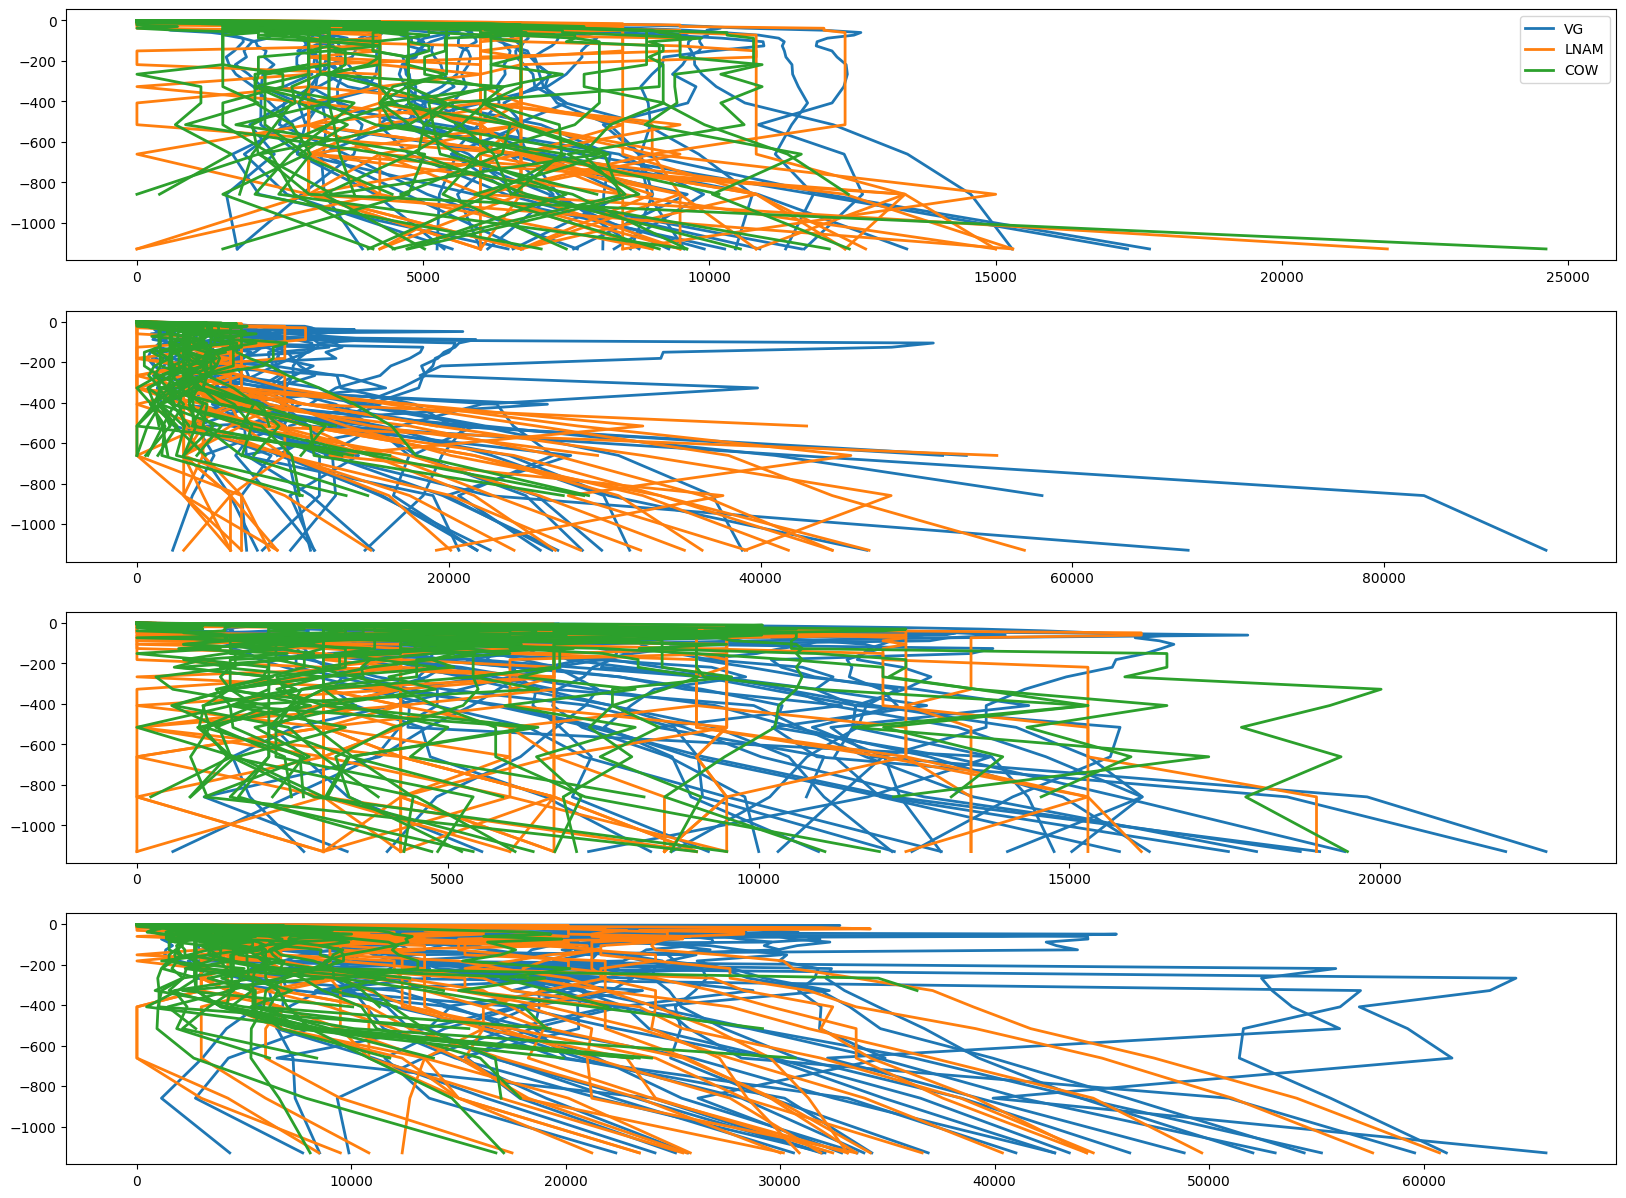

In [7]:
fig, axs = plt.subplots(4, 1, figsize=(20, 15), sharey=True)

method_colors = {method: plt.get_cmap('tab10')(i) for i, method in enumerate(['VG', 'LNAM', 'COW'])}
DEPTH_LVL_LIMIT = 23

for i, eddy in enumerate(the_frontier_eddies):
    for method, color in method_colors.items():
        for t in range(30):
            data = frontier_sample_data[eddy][f'T{t}'][method]
            x, y = data['x'].iloc[:DEPTH_LVL_LIMIT] - data.iloc[0]['x'], data['y'].iloc[:DEPTH_LVL_LIMIT] - data.iloc[0]['y']
            D = np.hypot(x, y)
            label = method if t == 0 else None
            axs[i].plot(D, data['Depth'].iloc[:DEPTH_LVL_LIMIT], color=color, linewidth=2, label=label)

axs[0].legend(loc='upper right')

plt.show()

